<a href="https://colab.research.google.com/github/Puisque/object-detection/blob/main/Formated_AlexNet_final_version_of_natural_scene_Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#mount googledrive

from google.colab import drive\

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Loading Gesture Images from Google Drive
import os 
import torch
import numpy as np
import time

import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
import torchvision.models



In [ ]:
# location on Google Drive
master_path = '/content/gdrive/MyDrive/Capstone/Code/natural scene dataset /natural scene'

train_dir = os.path.join(master_path, 'train/')
val_dir = os.path.join(master_path, 'validation/')
test_dir = os.path.join(master_path, 'test/')


# **Data Loading**

In [ ]:
def get_data_loader(batch_Size, directory,num_Workers=1):
    """ Loads images
    """
    transform = transforms.Compose([transforms.Resize((224,224)), 
                                    transforms.ToTensor()])
    
    data = datasets.ImageFolder(directory, transform=transform)

    classes = data.classes
  
    indices = list(range(len(data)))

    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(indices)

    data_sampler = SubsetRandomSampler(indices)
    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_Size,
                                               num_workers=num_Workers, sampler=data_sampler)
    
    return data_loader, classes

In [ ]:
train_loader, data_class_train = get_data_loader(1,train_dir, 1)

In [ ]:
print("Training data:", len(train_loader))
print(data_class_train)

Training data: 10494
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [ ]:
val_loader, data_class_val = get_data_loader(1, val_dir,1)

In [ ]:
print("Val data:", len(val_loader))
print(data_class_val)

Val data: 2622
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [ ]:
test_loader, data_class_test = get_data_loader(1,test_dir, 1)

In [ ]:
print("Test data:", len(test_loader))
print(data_class_test)

Test data: 2647
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


# **Data Visualization**

In [ ]:
def get_visualization(data_loader,data_class, num_images=20):

  fig = plt.figure(figsize=(25, 4))

  for i,(images,labels) in enumerate(data_loader,0):

    ax = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[0], (1, 2, 0)))
    ax.set_title(data_class[labels[0]])

    if i >= num_images-1:
        break


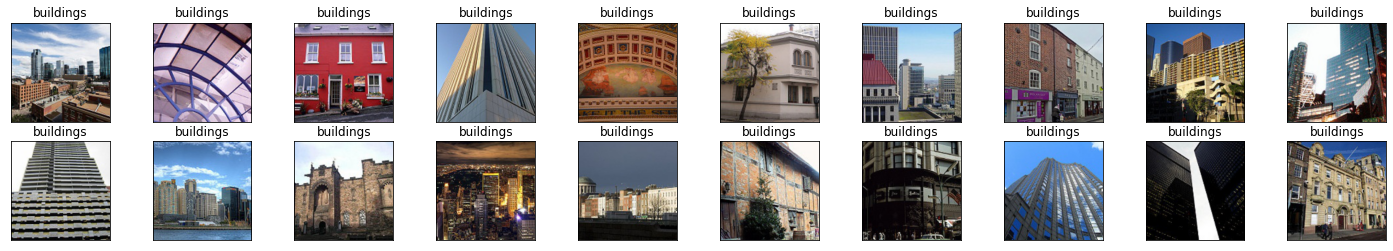

In [ ]:
get_visualization(train_loader,data_class_train,num_images = 20)

# **Transfer learning - Feature Extraction**

In [ ]:
torch.cuda.is_available ()

True

load the AlexNet network, with pretrained weights. PyTorch will download the pretrained weights from the internet.

In [ ]:
alexnet = torchvision.models.alexnet(pretrained=True)

In [ ]:
def features_to_folder(data_loader, master_path, classes):
    # save features to folder as tensors
    n = 0
    for img, label in data_loader:
      features = alexnet.features(img)
      features_tensor = torch.from_numpy(features.detach().numpy())
      for i, img in enumerate(img, 0):
        folder_name = master_path + str(classes[label[i]])
        print(folder_name)
        if not os.path.isdir(folder_name):
          os.makedirs(folder_name)
        torch.save(features_tensor[i], folder_name + '/' + str(n) + '.tensor')
        print(folder_name + '/' + str(n) + '.tensor')
      n += 1

In [ ]:
train_f = os.path.join(master_path, 'train_f/')
val_f = os.path.join(master_path, 'val_f/')
test_f = os.path.join(master_path, 'test_f/')

print(train_f)
print(val_f)
print(test_f)

/content/gdrive/MyDrive/Capstone/Code/natural scene dataset /natural scene/train_f/
/content/gdrive/MyDrive/Capstone/Code/natural scene dataset /natural scene/val_f/
/content/gdrive/MyDrive/Capstone/Code/natural scene dataset /natural scene/test_f/


In [ ]:
features_to_folder(train_loader, train_f,data_class_train)

In [ ]:
features_to_folder(val_loader, val_f,data_class_val)

In [ ]:
features_to_folder(test_loader, test_f,data_class_test)

Streaming output truncated to the last 5000 lines.
/content/gdrive/MyDrive/Capstone/Code/natural scene dataset /natural scene/test_f/forest
/content/gdrive/MyDrive/Capstone/Code/natural scene dataset /natural scene/test_f/forest/147.tensor
/content/gdrive/MyDrive/Capstone/Code/natural scene dataset /natural scene/test_f/buildings
/content/gdrive/MyDrive/Capstone/Code/natural scene dataset /natural scene/test_f/buildings/148.tensor
/content/gdrive/MyDrive/Capstone/Code/natural scene dataset /natural scene/test_f/sea
/content/gdrive/MyDrive/Capstone/Code/natural scene dataset /natural scene/test_f/sea/149.tensor
/content/gdrive/MyDrive/Capstone/Code/natural scene dataset /natural scene/test_f/glacier
/content/gdrive/MyDrive/Capstone/Code/natural scene dataset /natural scene/test_f/glacier/150.tensor
/content/gdrive/MyDrive/Capstone/Code/natural scene dataset /natural scene/test_f/buildings
/content/gdrive/MyDrive/Capstone/Code/natural scene dataset /natural scene/test_f/buildings/151.ten

# **Baseline Model**

Try **VGG19 and AlexNet**. Choose the one that has better accuracy for feature extraction.




In [ ]:
def train_base(model, train_loader,valid_loader,batch_size = 32,learning_rate = 0.001,num_epochs = 10):

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  iters, losses, train_acc, val_acc = [], [], [], []

  print ("Training Started...")
  start_time = time.time()

  # training
  for epoch in range(num_epochs):
      print('Epoch ： ', epoch)
      correct = 0
      total = 0
      for features, labels in iter(train_loader):
          #############################################
          #To Enable GPU Usage
          if use_cuda and torch.cuda.is_available():
            features = features.cuda()
            labels = labels.cuda()
          ############################################# 
            
          out = model(features)             # forward pass
          loss = criterion(out, labels) # compute the total loss
          loss.backward()               # backward pass (compute parameter updates)
          optimizer.step()              # make the updates for each parameter
          optimizer.zero_grad()         # a clean up step for PyTorch

          pred = out.max(1, keepdim=True)[1]
          correct += pred.eq(labels.view_as(pred)).sum().item()
          total += features.shape[0]

      # save the current training information
      iters.append(epoch)
      losses.append(float(loss)/batch_size)  # compute *average* loss
      train_acc.append(correct/total) 
      
      val_acc.append(get_accuracy_tp(model, valid_loader))  # compute validation accuracy
      print('Train Accuracy = {}, Validation Accuracy = {}'.format(train_acc[-1], val_acc[-1]))
  

  print('Finished Training')
  end_time = time.time()
  elapsed_time = end_time - start_time
  print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

  return losses, train_acc,val_acc,iters, model
    

In [ ]:
# If feature_extract = False, the model is finetuned and all model parameters are updated. 
# If feature_extract = True, only the last layer parameters are updated, the others remain fixed
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
train_loader_b, _= get_data_loader(32,train_dir, 1)
val_loader_b,_  = get_data_loader(32, val_dir,1)

## **AlexNet**

In [ ]:
baseline_model_alex = torchvision.models.alexnet(pretrained=True)
set_parameter_requires_grad(baseline_model_alex, feature_extracting = True)
num_ftrs = baseline_model_alex.classifier[6].in_features
baseline_model_alex.classifier[6] = nn.Linear(num_ftrs,6)
baseline_model_alex.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=6, bias=True)
)

In [ ]:
model_alex = torchvision.models.alexnet(pretrained=True)
set_parameter_requires_grad(model_alex, feature_extracting = True)
num_ftrs = model_alex.classifier[6].in_features
model_alex.classifier[6] = nn.Linear(num_ftrs,6)

use_cuda = True
if use_cuda and torch.cuda.is_available():
  model_alex.cuda()
  print('CUDA is available!')
else:
  print('CUDA is not available.')

losses_alex, train_acc_alex,val_acc_alex,iters_alex,model_alex = train_base(model_alex, train_loader_b,val_loader_b)


CUDA is available!
Training Started...
Epoch ：  0
Train Accuracy = 0.839622641509434, Validation Accuracy = 0.8653699466056446
Epoch ：  1
Train Accuracy = 0.8775490756622832, Validation Accuracy = 0.8607932875667429
Epoch ：  2
Train Accuracy = 0.8825042881646655, Validation Accuracy = 0.8630816170861938
Epoch ：  3
Train Accuracy = 0.8857442348008385, Validation Accuracy = 0.8691838291380626
Epoch ：  4
Train Accuracy = 0.8905088622069754, Validation Accuracy = 0.8604118993135011
Epoch ：  5
Train Accuracy = 0.8901276920144845, Validation Accuracy = 0.8607932875667429
Epoch ：  6
Train Accuracy = 0.8966075852868306, Validation Accuracy = 0.8688024408848207
Epoch ：  7
Train Accuracy = 0.8944158566800077, Validation Accuracy = 0.8733790999237223
Epoch ：  8
Train Accuracy = 0.8947970268724986, Validation Accuracy = 0.8554538520213577
Epoch ：  9
Train Accuracy = 0.8988946064417762, Validation Accuracy = 0.8718535469107551
Finished Training
Total time elapsed: 624.47 seconds


## **VGG19**

In [ ]:
baseline_model_vgg19_2 = torchvision.models.vgg19(pretrained=True)
set_parameter_requires_grad(baseline_model_vgg19_2, feature_extracting = True)
num_ftrs = baseline_model_vgg19_2.classifier[6].in_features
baseline_model_vgg19_2.classifier[6] = nn.Linear(num_ftrs,6)
baseline_model_vgg19_2.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=6, bias=True)
)

In [ ]:
model_vgg19_2 = torchvision.models.vgg19(pretrained=True)
set_parameter_requires_grad(model_vgg19_2, feature_extracting = True)
num_ftrs = model_vgg19_2.classifier[6].in_features
model_vgg19_2.classifier[6] = nn.Linear(num_ftrs,6)

use_cuda = True
if use_cuda and torch.cuda.is_available():
  model_vgg19_2.cuda()
  print('CUDA is available!')
else:
  print('CUDA is not available.')

losses_vgg, train_acc_vgg,val_acc_vgg,iters_vgg,model_vgg = train_base(model_vgg19_2, train_loader_b,val_loader_b)


CUDA is available!
Training Started...
Epoch ：  0
Train Accuracy = 0.8626834381551363, Validation Accuracy = 0.8661327231121282
Epoch ：  1
Train Accuracy = 0.8854583571564704, Validation Accuracy = 0.8699466056445462
Epoch ：  2
Train Accuracy = 0.8893653516295026, Validation Accuracy = 0.8703279938977879
Epoch ：  3
Train Accuracy = 0.8943205641318849, Validation Accuracy = 0.8825324180015256
Epoch ：  4
Train Accuracy = 0.8955593672574804, Validation Accuracy = 0.8871090770404272
Epoch ：  5
Train Accuracy = 0.8947970268724986, Validation Accuracy = 0.8768115942028986
Epoch ：  6
Train Accuracy = 0.8907947398513436, Validation Accuracy = 0.8581235697940504
Epoch ：  7
Train Accuracy = 0.8947017343243758, Validation Accuracy = 0.8604118993135011
Epoch ：  8
Train Accuracy = 0.8955593672574804, Validation Accuracy = 0.872234935163997
Epoch ：  9
Train Accuracy = 0.9016580903373356, Validation Accuracy = 0.8756674294431731
Finished Training
Total time elapsed: 794.77 seconds


## **Result**:

VGG19 has higher accuracy. VGG19 takes much longer time. 

The two models has similar classifier, which means VGG19 should performs better in feature extraction. 

# **Architecture**

In [ ]:
class CNN_AlexNet(nn.Module):
      
    def __init__(self):
        self.name = "CNN_AlexNet"
        super(CNN_AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(256, 60, 2) #in_channels, out_chanels, kernel_size
        self.conv2 = nn.Conv2d(60, 10, 2) #in_channels, out_chanels, kernel_size
        
        self.fc1 = nn.Linear(160, 32)
        self.fc2 = nn.Linear(32, 6)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 160)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# **Train Model**

In [ ]:
# load features
# location on Google Drive
train_path = '/content/gdrive/MyDrive/Capstone/Code/natural scene dataset /natural scene/train_f'
valid_path = '/content/gdrive/MyDrive/Capstone/Code/natural scene dataset /natural scene/val_f'
test_path = '/content/gdrive/MyDrive/Capstone/Code/natural scene dataset /natural scene/test_f'

# Load data from Google Drive
train_loader1 = torchvision.datasets.DatasetFolder(train_path, loader=torch.load, extensions=('.tensor'))
val_loader1 = torchvision.datasets.DatasetFolder(valid_path, loader=torch.load, extensions=('.tensor'))
test_loader1 = torchvision.datasets.DatasetFolder(test_path, loader=torch.load, extensions=('.tensor'))

In [ ]:
print(len(train_loader1))
print(len(val_loader1))
print(len(test_loader1))

10493
2622
2647


In [ ]:
torch.cuda.is_available ()

True

In [ ]:
def plot_curve(losses, train_acc,val_acc,iters):
  # plotting
  plt.title("Training Curve")
  plt.plot(iters, losses, label="Train")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.show()
  plt.title("Training Curve")
  plt.plot(iters, train_acc, label="Train")
  plt.plot(iters, val_acc, label="Validation")
  plt.xlabel("Iterations")
  plt.ylabel("Training Accuracy")
  plt.legend(loc='best')
  plt.show()

In [ ]:
def get_accuracy_tp(model, data):

    correct = 0
    total = 0
    for imgs, labels in data:
        
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
               
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total


In [ ]:
def train(model, train_dataset,valid_dataset,batch_size = 32,learning_rate = 0.001,num_epochs = 20):

  num_workers = 1
  # indices_train = list(range(len(train_dataset)))
  # np.random.shuffle(indices_train)
  # print(int(len(indices_train)/4))
  # train_sampler = SubsetRandomSampler(indices_train[:int(len(indices_train)/4)])
  # train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
  #                                           num_workers=num_workers,sampler=train_sampler,shuffle=True)
    
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                            num_workers=num_workers,shuffle=True)
  valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, 
                                            num_workers=num_workers, shuffle=True)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  iters, losses, train_acc, val_acc = [], [], [], []

  print ("Training Started...")
  start_time = time.time()

  # training
  for epoch in range(num_epochs):
      print('Epoch ： ', epoch)
      total = 0
      correct = 0
      for features, labels in iter(train_loader):
          #############################################
          #To Enable GPU Usage
          if use_cuda and torch.cuda.is_available():
            features = features.cuda()
            labels = labels.cuda()
          ############################################# 
            
          out = model(features)             # forward pass
          loss = criterion(out, labels) # compute the total loss
          loss.backward()               # backward pass (compute parameter updates)
          optimizer.step()              # make the updates for each parameter
          optimizer.zero_grad()         # a clean up step for PyTorch

          pred = out.max(1, keepdim=True)[1]
          correct += pred.eq(labels.view_as(pred)).sum().item()
          total += features.shape[0]

      # save the current training information
      iters.append(epoch)
      losses.append(float(loss)/batch_size)  # compute *average* loss
      # train_acc.append(get_accuracy_tp(model, train_loader, valid_loader, train=True)) # compute training accuracy
      train_acc.append(correct / total) # compute training accuracy
      
      val_acc.append(get_accuracy_tp(model, train_loader, valid_loader, train=False))  # compute validation accuracy
      print('Train Accuracy = {}, Validation Accuracy = {}'.format(train_acc[-1], val_acc[-1]))
  
  
  model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, learning_rate, num_epochs)
  torch.save(model.state_dict(), model_path)

  print('Finished Training')
  end_time = time.time()
  elapsed_time = end_time - start_time
  print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

  return losses, train_acc,val_acc,iters, model
    

## **Basic Model**

In [ ]:
use_cuda = True
model = CNN_AlexNet()
if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

batch_size=32
learning_rate=0.001
num_epochs=20

losses, train_acc,val_acc,iters,model = train(model, train_loader1,val_loader1,batch_size = batch_size,learning_rate=learning_rate,num_epochs =num_epochs )

plot_curve(losses, train_acc,val_acc,iters)

CUDA is available!  Training on GPU ...
Training Started...
Epoch ：  0


KeyboardInterrupt: ignored

CUDA is available!  Training on GPU ...
Training Started...
Epochch ：  0
0.6905556085009054 0.6876430205949656
Epochch ：  1
0.7945296864576384 0.7837528604118993
Epochch ：  2
0.8284570666158392 0.8070175438596491
Epochch ：  3
0.8697226722576956 0.864607170099161
Epochch ：  4
0.8789669303345087 0.8729977116704806
Epochch ：  5
0.8943104927094253 0.8806254767353165
Epochch ：  6
0.9038406556752121 0.8844393592677345
Epochch ：  7
0.8987896693033451 0.8806254767353165
Epochch ：  8
0.9119412941961308 0.88558352402746
Epochch ：  9
0.9170875821976556 0.893211289092296
Epochch ：  10
0.922519775088154 0.900839054157132
Epochch ：  11
0.9254741256075479 0.8985507246376812
Epochch ：  12
0.8999332888592395 0.8787185354691075
Epochch ：  13
0.9320499380539408 0.8958810068649885
Epochch ：  14
0.934718383684361 0.897025171624714
Epochch ：  15
0.9378633374630706 0.897025171624714
Epochch ：  16
0.9350042885733346 0.8947368421052632
Epochch ：  17
0.9462498808729629 0.8996948893974066
Epochch ：  18
0.9428190

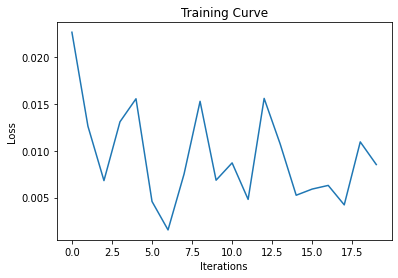

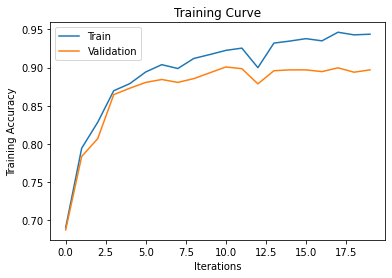

In [ ]:
use_cuda = True
model = CNN_AlexNet()
if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

batch_size=32
learning_rate=0.001
num_epochs=20

losses, train_acc,val_acc,iters,model = train(model, train_loader1,val_loader1,batch_size = batch_size,learning_rate=learning_rate,num_epochs =num_epochs )

plot_curve(losses, train_acc,val_acc,iters)

In [ ]:
use_cuda = True
model = CNN_AlexNet()
if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

batch_size=32
learning_rate=0.001
num_epochs=20

losses, train_acc,val_acc,iters,model = train(model, train_loader1,val_loader1,batch_size = batch_size,learning_rate=learning_rate,num_epochs =num_epochs )

plot_curve(losses, train_acc,val_acc,iters)

## **Model Tunning**

Plan:
1. Try VGG19 and ResNet for featrue extraction first
2. Learning rate && batch size && number of epochs
3. Adjust architecture (e.g. # of layers, # of neurons, dropout)

After seeing some improvement in model performance, add early stopping and cross validation 


## Test Accuracy 

In [ ]:
num_workers = 1
test_loader = torch.utils.data.DataLoader(test_loader1, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)


In [ ]:
def get_test_accuracy(model, test_loader):
    data = test_loader
    correct = 0
    total = 0
    for features, labels in data:
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          features = features.cuda()
          labels = labels.cuda()
        #############################################
        
        
        output = model(features)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += features.shape[0]
    return correct / total


In [ ]:

test_accuracy = get_test_accuracy(model, test_loader)

print("test accuracy:", test_accuracy)

test accuracy: 0.887797506611258
